In [39]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(options=options)

categories = {
    "apartments": "https://krisha.kz/prodazha/kvartiry/",
    "houses": "https://krisha.kz/prodazha/doma-dachi/",
    "business": "https://krisha.kz/prodazha/biznes/"
}

def scrape_category(category_url, max_pages=170):
    data = []
    for page in range(1, max_pages + 1):
        url = f"{category_url}?page={page}"
        print(f"Scraping page: {url}")
        driver.get(url)
        time.sleep(5)

        try:
            WebDriverWait(driver, 15).until(
                EC.presence_of_all_elements_located((By.CLASS_NAME, "a-card__inc"))
            )
        except Exception as e:
            print(f"Error loading page {page}: {e}")
            continue

        soup = BeautifulSoup(driver.page_source, "html.parser")
        products = soup.find_all("div", class_="a-card__inc")

        for product in products:
            try:
                title_tag = product.find("a", class_="a-card__title")
                title = title_tag.text.strip() if title_tag else "Нет названия"
                
                price_tag = product.find("div", class_="a-card__price")
                price = price_tag.text.strip().replace("\xa0", "").replace("\u20b8", "₸") if price_tag else "Нет цены"
                
                location_tag = product.find("div", class_="a-card__stats-item")
                location = location_tag.text.strip() if location_tag else "Нет локации"
                
                published_day_tag = product.find_all("div", class_="a-card__stats-item")
                published_day = published_day_tag[1].text.strip() if len(published_day_tag) > 1 else "Нет даты"
                
                views_tag = product.find("span", class_="a-view-count")
                views = views_tag.text.strip() if views_tag else "0"

                data.append({
                    "Title": title,
                    "Price": price,
                    "Location": location,
                    "Published_Day": published_day,
                    "Views": views
                })
            except Exception as e:
                print(f"Error parsing product: {e}")
                continue

    return pd.DataFrame(data)

all_data = {}
for category, url in categories.items():
    print(f"Scraping category: {category}")
    df = scrape_category(url)
    all_data[category] = df

for category, df in all_data.items():
    if not df.empty:
        file_name = f"krisha_{category}_data.csv"
        df.to_csv(file_name, index=False, encoding="utf-8")
        print(f"Saved {file_name} with {len(df)} rows")
    else:
        print(f"No data scraped for category {category}.")
driver.quit()

Scraping category: apartments
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=1
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=2
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=3
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=4
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=5
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=6
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=7
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=8
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=9
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=10
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=11
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=12
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=13
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=14
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=15
Scraping page: https://krisha.kz/prodazha/kvartiry/?page=16
Scraping page: http

In [7]:
import pandas as pd

def process_apartments(file_path):
    df = pd.read_csv(file_path)
    df['Rooms'] = df['Title'].str.extract(r'(\d+)-комнатная')
    df['Area'] = df['Title'].str.extract(r'(\d+\.?\d*)\sм²')
    df['Floor'] = df['Title'].str.extract(r'(\d+)/\d+ этаж')
    df['Rooms'] = pd.to_numeric(df['Rooms'], errors='coerce').fillna(0).astype(int)
    df['Area'] = pd.to_numeric(df['Area'], errors='coerce').fillna(0.0).astype(float)
    df['Floor'] = pd.to_numeric(df['Floor'], errors='coerce').fillna(0).astype(int)
    df.to_csv(file_path, encoding='utf-8')

def process_business(file_path):
    df = pd.read_csv(file_path)
    df['Rooms'] = 1
    df['Area'] = df['Title'].str.extract(r'(\d+\.?\d*)\sм²')
    df['Floor'] = 1
    df['Area'] = pd.to_numeric(df['Area'], errors='coerce').fillna(0.0).astype(float)
    df.to_csv(file_path, encoding='utf-8')

def process_houses(file_path):
    df = pd.read_csv(file_path)
    df['Rooms'] = df['Title'].str.extract(r'(\d+) комнат')
    df['Area'] = df['Title'].str.extract(r'(\d+\.?\d*)\sм²')
    df['Floor'] = 1
    df['Rooms'] = pd.to_numeric(df['Rooms'], errors='coerce').fillna(0).astype(int)
    df['Area'] = pd.to_numeric(df['Area'], errors='coerce').fillna(0.0).astype(float)
    df.to_csv(file_path, index=False, encoding='utf-8')

process_apartments('krisha_data.csv')
process_business('business_data.csv')
process_houses('doma_data.csv')

In [8]:
def process_business(file_path):
    df = pd.read_csv(file_path)
    df['Price'] = df['Price'].astype(str).str.replace(r'[^\d]', '', regex=True).astype(int)
    df.to_csv(file_path, index=False, encoding='utf-8')

def process_houses(file_path):
    df = pd.read_csv(file_path)
    df['Price'] = df['Price'].astype(str).str.replace(r'[^\d]', '', regex=True).astype(int)
    df.to_csv(file_path, index=False, encoding='utf-8')

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

apartments = pd.read_csv("krisha_data.csv")
business = pd.read_csv("business_data.csv")
houses = pd.read_csv("doma_data.csv")

apartments["Category"] = "Apartments"
business["Category"] = "Business"
houses["Category"] = "Houses"

data = pd.concat([apartments, business, houses], ignore_index=True)

In [10]:
data = data.dropna(subset=["Price"])

In [11]:
print(data.describe())

       Unnamed: 0.1   Unnamed: 0         Rooms           Area         Floor
count   6806.000000  6806.000000  10209.000000   10209.000000  10209.000000
mean    1701.000000  1701.000000      2.764913     685.134528      2.311098
std      982.433617   982.433617      2.195299    5704.330947      3.028599
min        0.000000     0.000000      0.000000       1.000000      0.000000
25%      850.250000   850.250000      1.000000      55.500000      1.000000
50%     1701.000000  1701.000000      2.000000      96.000000      1.000000
75%     2551.750000  2551.750000      4.000000     195.000000      2.000000
max     3402.000000  3402.000000     50.000000  110000.000000     22.000000


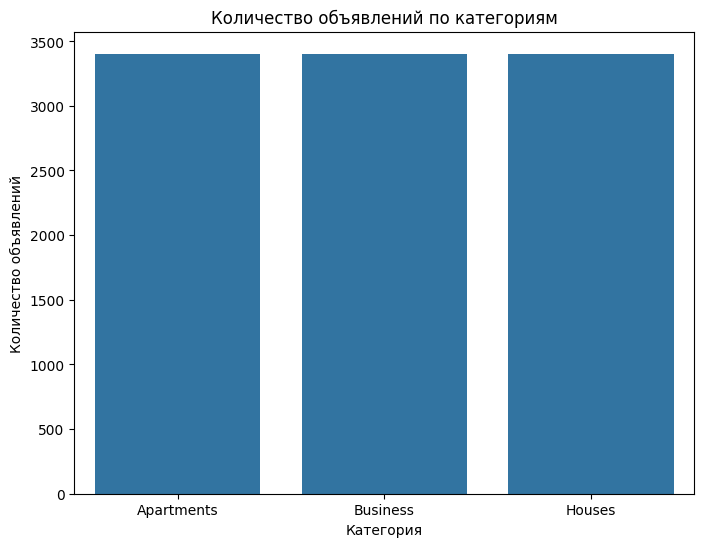

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Category", data=data)
plt.title("Количество объявлений по категориям")
plt.xlabel("Категория")
plt.ylabel("Количество объявлений")
plt.show()

In [13]:
data = pd.read_csv('krisha_data.csv')
data['Category'] = 'apartments'   # <-- сюда подставьте нужное имя категории
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')


In [14]:
import pandas as pd

# Читаем каждый и сразу маркируем
df_ap = pd.read_csv('krisha_data.csv')
df_ap['Category'] = 'apartments'

df_h  = pd.read_csv('doma_data.csv')
df_h['Category'] = 'houses'

df_b  = pd.read_csv('business_data.csv')
df_b['Category'] = 'business'

# Объединяем всё вместе
data = pd.concat([df_ap, df_h, df_b], ignore_index=True)

# Приводим Price к числу
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')


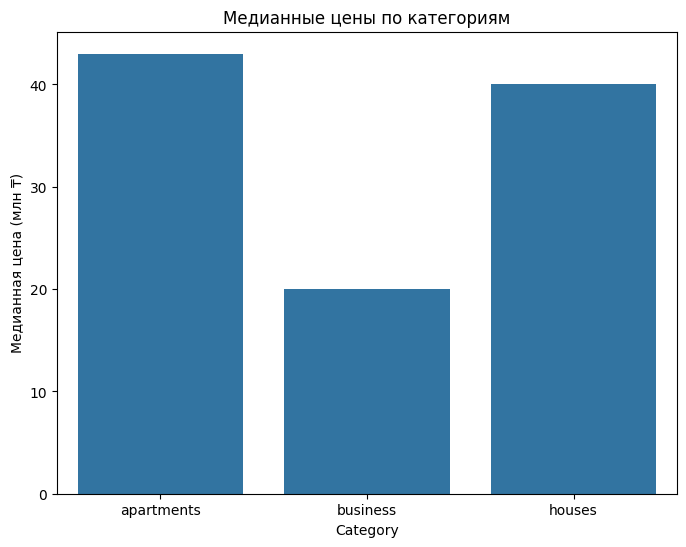

In [15]:
import pandas as pd

# Загрузка данных
df_ap = pd.read_csv('krisha_data.csv')
df_ap['Category'] = 'apartments'
df_ap['Price'] = pd.to_numeric(df_ap['Price'].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')

df_bs = pd.read_csv('business_data.csv')
df_bs['Category'] = 'business'
df_bs['Price'] = pd.to_numeric(df_bs['Price'].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')

df_hs = pd.read_csv('doma_data.csv')
df_hs['Category'] = 'houses'
df_hs['Price'] = pd.to_numeric(df_hs['Price'].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')

# Объединяем в один датафрейм
data = pd.concat([df_ap, df_bs, df_hs], ignore_index=True)

# Считаем медианные цены
median_prices = (
    data
    .groupby("Category", as_index=False)['Price']
    .median()
)

# Переводим в миллионы тенге
median_prices["Price"] = median_prices["Price"] / 1e6

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(x="Category", y="Price", data=median_prices)
plt.title("Медианные цены по категориям")
plt.ylabel("Медианная цена (млн ₸)")
plt.show()


In [16]:
median_prices = (
    data
    .groupby("Category", as_index=False)['Price']
    .median()
)

# Переводим в миллионы
median_prices["Price"] = median_prices["Price"] / 1e6

print(median_prices)


     Category  Price
0  apartments   43.0
1    business   20.0
2      houses   40.0


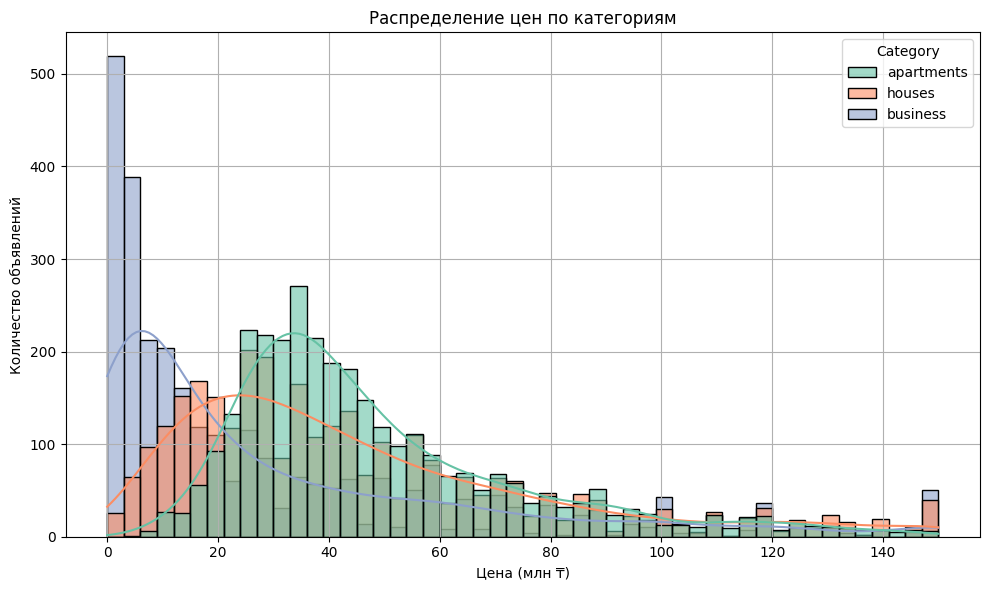

In [17]:
data = pd.concat([df_ap, df_hs, df_bs], ignore_index=True)

# Удалим выбросы: например, цены выше 150 млн ₸
data = data[data['Price'] <= 150_000_000]

# Переведём в миллионы для визуализации
data['Price_mln'] = data['Price'] / 1e6

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Price_mln', hue='Category', kde=True, bins=50, palette='Set2', alpha=0.6)
plt.title('Распределение цен по категориям')
plt.xlabel('Цена (млн ₸)')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.tight_layout()

plt.show()

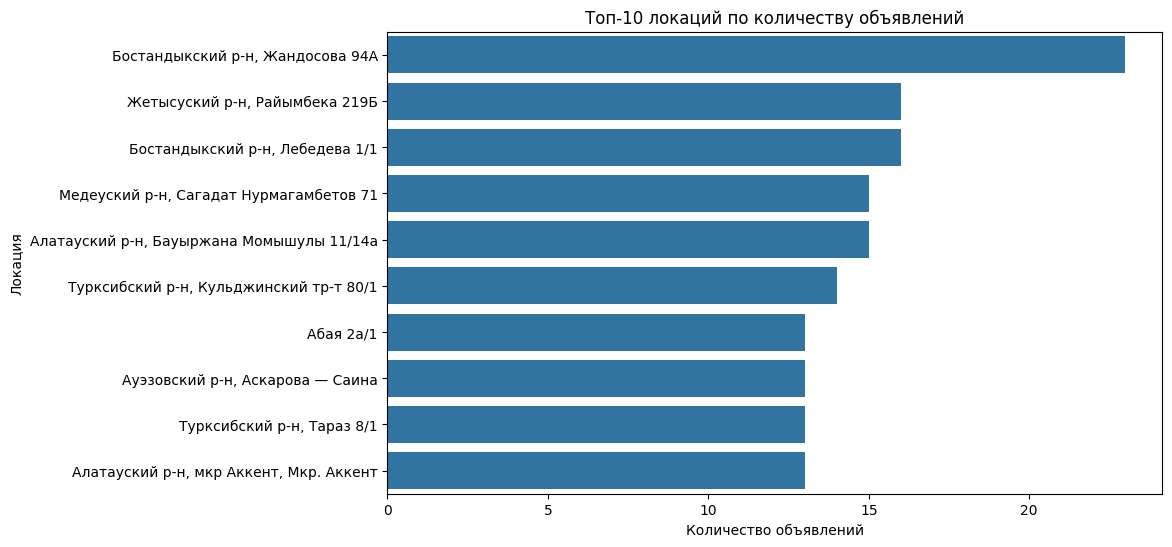

In [18]:
top_locations = data["Location"].value_counts().head(10).reset_index()
top_locations.columns = ["Location", "Count"]
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Location", data=top_locations)
plt.title("Топ-10 локаций по количеству объявлений")
plt.xlabel("Количество объявлений")
plt.ylabel("Локация")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_10896\304400038.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Price_mln'] = filtered_data['Price'] / 1e6


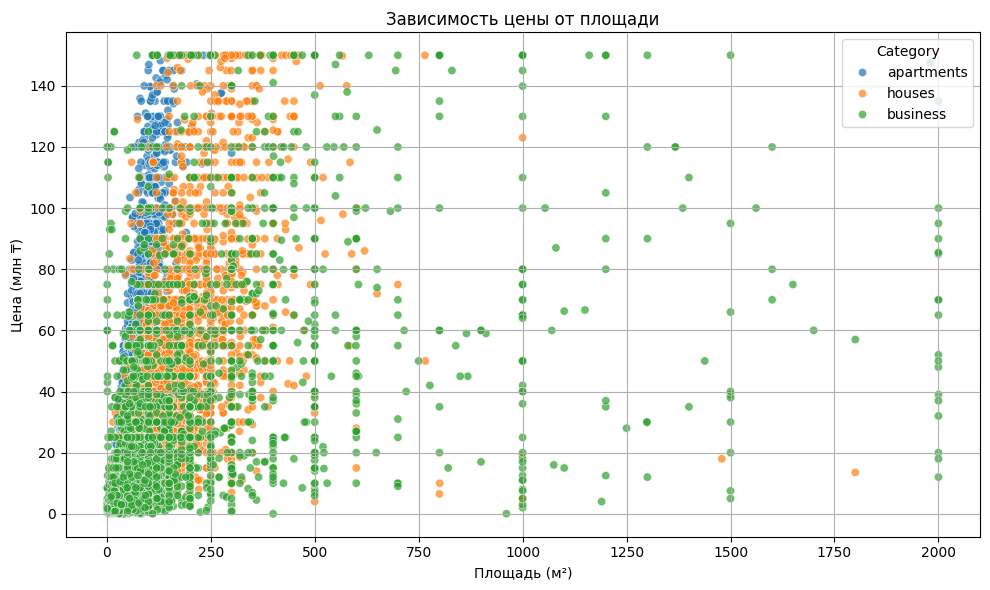

In [20]:
filtered_data = data[data['Area'] <= 2000]

# Перевод цены в миллионы
filtered_data['Price_mln'] = filtered_data['Price'] / 1e6

# Построение графика
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area', y='Price_mln', hue='Category', data=filtered_data, alpha=0.7)
plt.title("Зависимость цены от площади")
plt.xlabel("Площадь (м²)")
plt.ylabel("Цена (млн ₸)")
plt.grid(True)
plt.tight_layout()
plt.show()


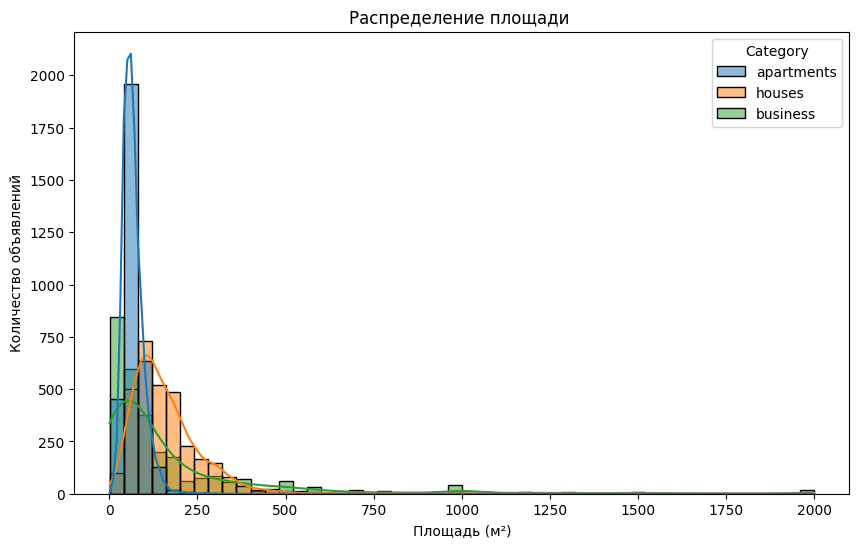

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, x="Area", hue="Category", kde=True, bins=50)
plt.title("Распределение площади ")
plt.xlabel("Площадь (м²)")
plt.ylabel("Количество объявлений")
plt.show()

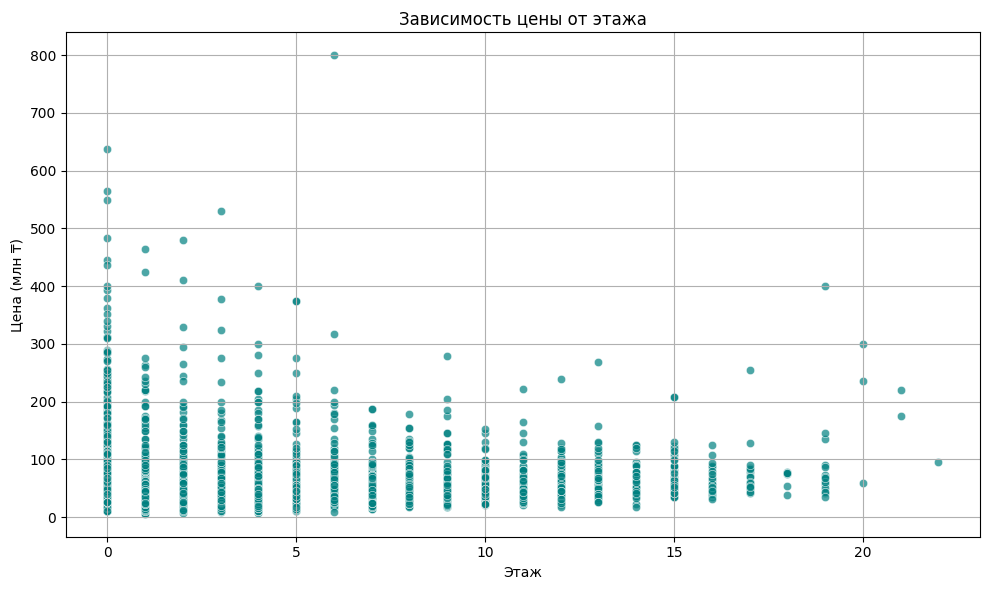

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка только квартир
df_ap = pd.read_csv('krisha_data.csv')
df_ap['Category'] = 'apartments'

# Приведение типов
df_ap['Price'] = pd.to_numeric(df_ap['Price'].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')
df_ap['Floor'] = pd.to_numeric(df_ap['Floor'], errors='coerce')

# Удаление пропусков и фильтрация по этажам
df_ap = df_ap.dropna(subset=['Price', 'Floor'])
df_ap = df_ap[df_ap['Floor'] <= 50]

# Перевод цены в миллионы
df_ap['Price_mln'] = df_ap['Price'] / 1e6

# Построение графика
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Floor", y="Price_mln", data=df_ap, alpha=0.7, color='teal')
plt.title("Зависимость цены от этажа")
plt.xlabel("Этаж")
plt.ylabel("Цена (млн ₸)")
plt.grid(True)
plt.tight_layout()
plt.show()


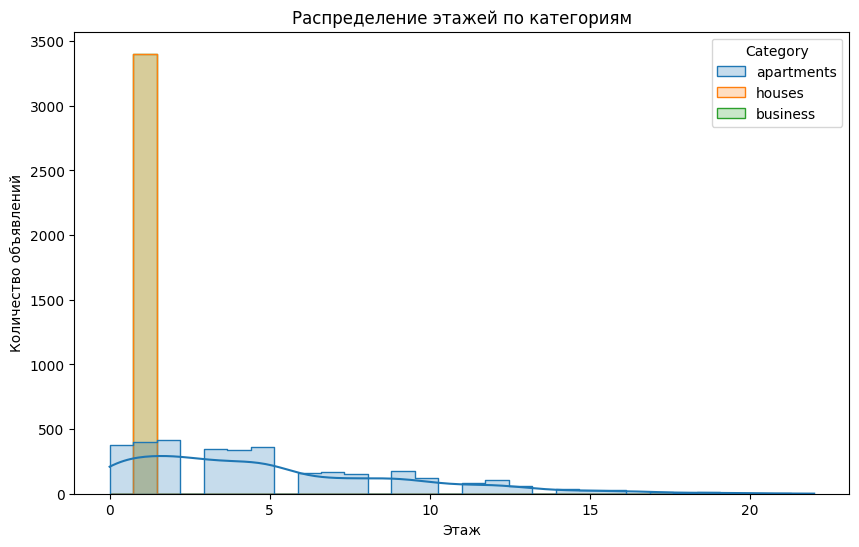

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузим и объединим все категории, если ты этого ещё не сделал:
df_apartments = pd.read_csv("krisha_data.csv")
df_apartments["Category"] = "apartments"

df_houses = pd.read_csv("doma_data.csv")
df_houses["Category"] = "houses"

df_business = pd.read_csv("business_data.csv")
df_business["Category"] = "business"

# Объединяем
data = pd.concat([df_apartments, df_houses, df_business], ignore_index=True)

# Удаляем строки без "Floor" и "Category"
data = data.dropna(subset=["Floor", "Category"])

# Убедимся, что колонка Floor числовая
data["Floor"] = pd.to_numeric(data["Floor"], errors="coerce")

# Строим график
plt.figure(figsize=(10, 6))
sns.histplot(data, x="Floor", hue="Category", element="step", kde=True, bins=30)
plt.title("Распределение этажей по категориям")
plt.xlabel("Этаж")
plt.ylabel("Количество объявлений")
plt.show()


,Customer_ID,Age,Family_Status,Preferred_Area,Rooms,Preferred_Floor,Budget_mln,Purpose
0,1,36,один,Ауэзовский,1,3,50.4,инвестиции
1,2,33,пенсионеры,Ауэзовский,3,3,36.0,инвестиции
2,3,40,семья с детьми,Наурызбайский,3,1,31.5,инвестиции
3,4,40,пенсионеры,Наурызбайский,1,8,36.1,сдача в аренду
4,5,50,семья с детьми,Наурызбайский,2,8,79.1,сдача в аренду


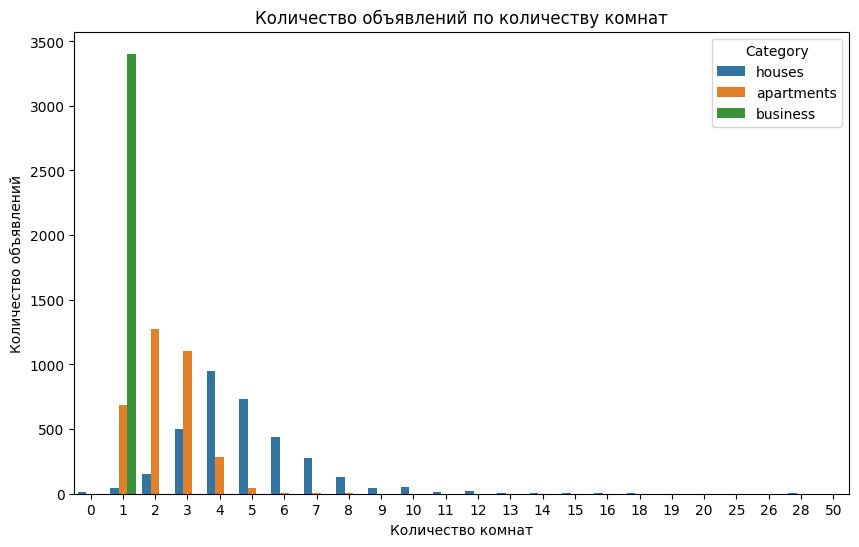

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Rooms", hue="Category", data=data)
plt.title("Количество объявлений по количеству комнат")
plt.xlabel("Количество комнат")
plt.ylabel("Количество объявлений")
plt.show()

In [28]:
import pandas as pd
import numpy as np

# Количество строк
n = 10000

# Возможные значения
areas = ["Бостандыкский", "Наурызбайский", "Турксибский", "Алатауский", "Ауэзовский", "Медеуский"]
family_statuses = ["один", "пара", "семья с детьми", "пенсионеры"]
purposes = ["инвестиции", "для жизни", "сдача в аренду"]
budgets = np.random.normal(loc=45, scale=15, size=n).clip(10, 150)  # млн ₸

# Генерация датасета
customers = pd.DataFrame({
    "Customer_ID": range(1, n + 1),
    "Age": np.random.randint(22, 65, size=n),
    "Family_Status": np.random.choice(family_statuses, size=n),
    "Preferred_Area": np.random.choice(areas, size=n),
    "Rooms": np.random.choice([1, 2, 3, 4], size=n, p=[0.3, 0.4, 0.2, 0.1]),
    "Preferred_Floor": np.random.randint(1, 18, size=n),
    "Budget_mln": budgets.round(1),
    "Purpose": np.random.choice(purposes, size=n)
})

customers.head()

,Customer_ID,Age,Family_Status,Preferred_Area,Rooms,Preferred_Floor,Budget_mln,Purpose
0,1,27,семья с детьми,Ауэзовский,3,7,61.7,сдача в аренду
1,2,61,семья с детьми,Бостандыкский,4,7,31.3,сдача в аренду
2,3,61,пенсионеры,Бостандыкский,2,5,65.9,сдача в аренду
3,4,24,пара,Турксибский,3,6,42.7,инвестиции
4,5,54,один,Медеуский,3,1,25.0,инвестиции


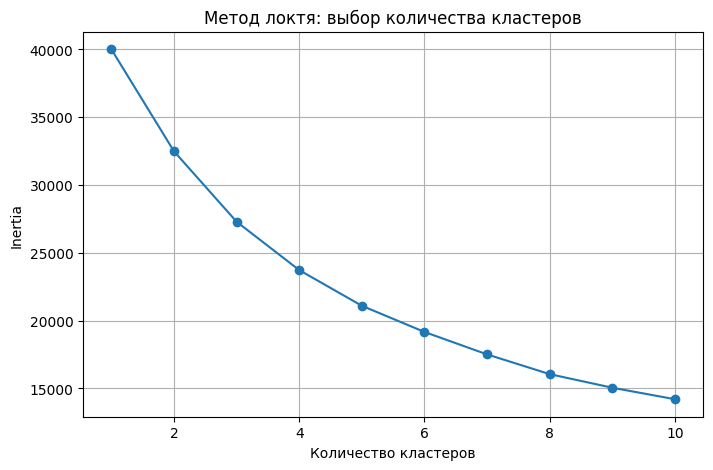

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных для кластеризации
features = ["Age", "Rooms", "Preferred_Floor", "Budget_mln"]
X = customers[features]

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Выбор оптимального количества кластеров по методу локтя
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация локтя
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Метод локтя: выбор количества кластеров")
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

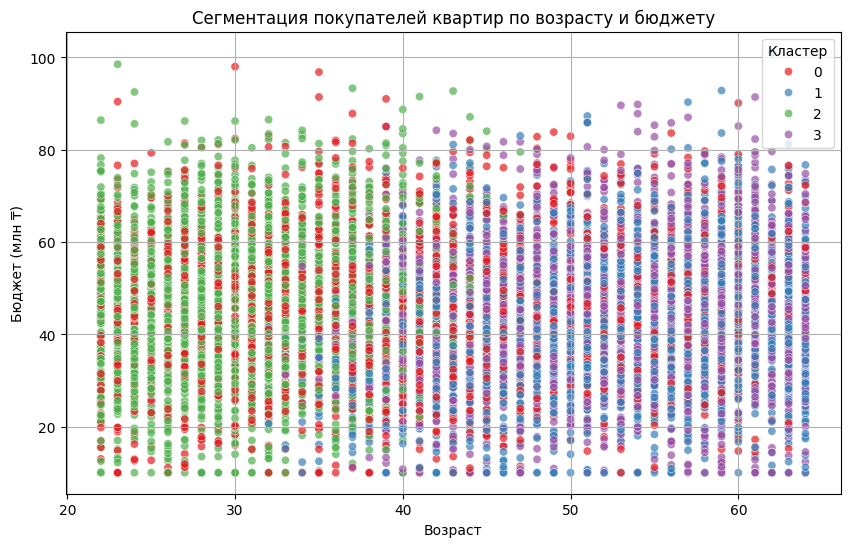

In [30]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Обучаем модель кластеризации
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customers["Cluster"] = kmeans.fit_predict(X_scaled)

# Визуализируем кластеры по возрасту и бюджету
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customers,
    x="Age", y="Budget_mln",
    hue="Cluster", palette="Set1", alpha=0.7
)
plt.title("Сегментация покупателей квартир по возрасту и бюджету")
plt.xlabel("Возраст")
plt.ylabel("Бюджет (млн ₸)")
plt.grid(True)
plt.legend(title="Кластер")
plt.show()


🟢 Кластер 0: Молодые экономные покупатели
Возраст: до 30 лет

Бюджет: низкий (до 30 млн ₸)

Описание: Студенты, молодые специалисты или пары. Часто рассматривают 1-комнатные квартиры или студии на окраинах или в старом жилом фонде.

🔵 Кластер 1: Средний класс
Возраст: 30–45 лет

Бюджет: 30–60 млн ₸

Описание: Стабильные семьи со средним доходом, ищут 2–3-комнатные квартиры в спальных районах с хорошей инфраструктурой.

🟡 Кластер 2: Премиум-сегмент
Возраст: 35–55 лет

Бюджет: 70 млн ₸ и выше

Описание: Бизнесмены, владельцы компаний или инвесторы. Покупают жильё в новых ЖК или центрах городов, часто для инвестиций или аренды.

🔴 Кластер 3: Пенсионеры или вложенцы
Возраст: 55+

Бюджет: 20–40 млн ₸

Описание: Покупают жильё для детей, внуков, либо для спокойной жизни. Предпочитают первый этаж, дома с удобствами, часто не в центре.

Random Forest Model:
Mean Squared Error: 1223624803698686.0
R^2: 0.5856277891611414

Gradient Boosting Model:
Mean Squared Error: 1208641842944231.5
R^2: 0.5907016668350562


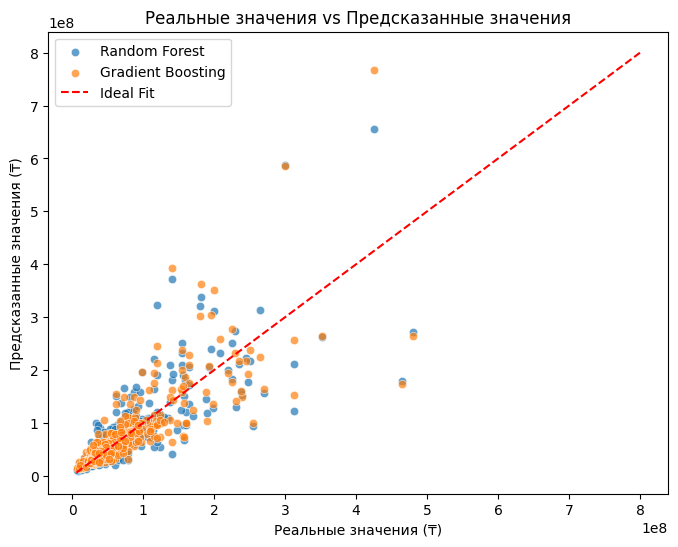

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем данные
data = pd.read_csv('krisha_data.csv')

# Очистим данные
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
data['Rooms'] = pd.to_numeric(data['Rooms'], errors='coerce')
data['Area'] = pd.to_numeric(data['Area'], errors='coerce')
data['Floor'] = pd.to_numeric(data['Floor'], errors='coerce')

# Удаляем строки с пропусками
data = data.dropna(subset=['Price', 'Rooms', 'Area', 'Floor'])

# Разделяем данные на признаки (X) и целевую переменную (y)
X = data[['Rooms', 'Area', 'Floor']]  # Исключили признак 'Location'
y = data['Price']

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Модель случайного леса
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания случайного леса
y_rf_pred = rf_model.predict(X_test)

# 2. Модель градиентного бустинга
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Предсказания градиентного бустинга
y_gb_pred = gb_model.predict(X_test)

# Оценка моделей
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

gb_mse = mean_squared_error(y_test, y_gb_pred)
gb_r2 = r2_score(y_test, y_gb_pred)

# Выводим результаты
print("Random Forest Model:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R^2: {rf_r2}")

print("\nGradient Boosting Model:")
print(f"Mean Squared Error: {gb_mse}")
print(f"R^2: {gb_r2}")

# Визуализируем результаты
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_rf_pred, alpha=0.7, label="Random Forest")
sns.scatterplot(x=y_test, y=y_gb_pred, alpha=0.7, label="Gradient Boosting")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', label="Ideal Fit")
plt.title("Реальные значения vs Предсказанные значения")
plt.xlabel("Реальные значения (₸)")
plt.ylabel("Предсказанные значения (₸)")
plt.legend()
plt.show()

In [4]:
import joblib
joblib.dump(model, "model.pkl")


['model.pkl']

In [3]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Загрузка модели
model = joblib.load('apartment_price_predictor_rf_model.joblib')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Получаем данные из запроса
        data = request.get_json()
        df = pd.DataFrame(data, index=[0])
        
        # Делаем предсказание
        prediction = model.predict(df)
        return jsonify({'price': prediction[0]})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == "__main__":
    app.run(debug=False, port=5001)



 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit


In [91]:
python app.py



SyntaxError: invalid syntax (446455597.py, line 1)

Mean Squared Error: 1025639750507667.5
R^2 Score: 0.6526740797853818


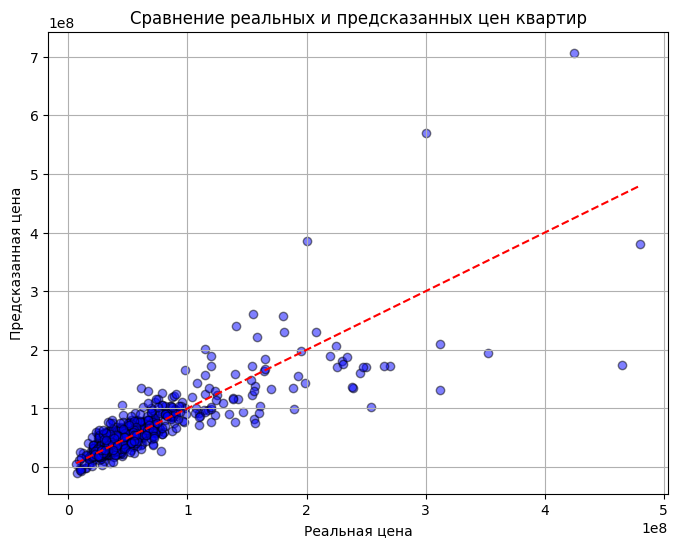

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Загрузка данных
data = pd.read_csv("krisha_data.csv")

# Очистка
data["Price"] = pd.to_numeric(data["Price"], errors="coerce")
data = data.dropna(subset=["Price", "Rooms", "Area", "Floor"])

# Выбор признаков
X = data[["Rooms", "Area", "Floor"]]
y = data["Price"]

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Сохранение модели
joblib.dump(model, "model.pkl")

# Визуализация: реальные vs предсказанные цены
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Реальная цена")
plt.ylabel("Предсказанная цена")
plt.title("Сравнение реальных и предсказанных цен квартир")
plt.grid(True)
plt.show()


Cross-Validation R-squared scores: [0.00392584 0.47574148 0.08814115 0.47732984 0.33949631]
Mean R-squared: 0.28
Mean Squared Error: 0.13
R-squared: 0.93


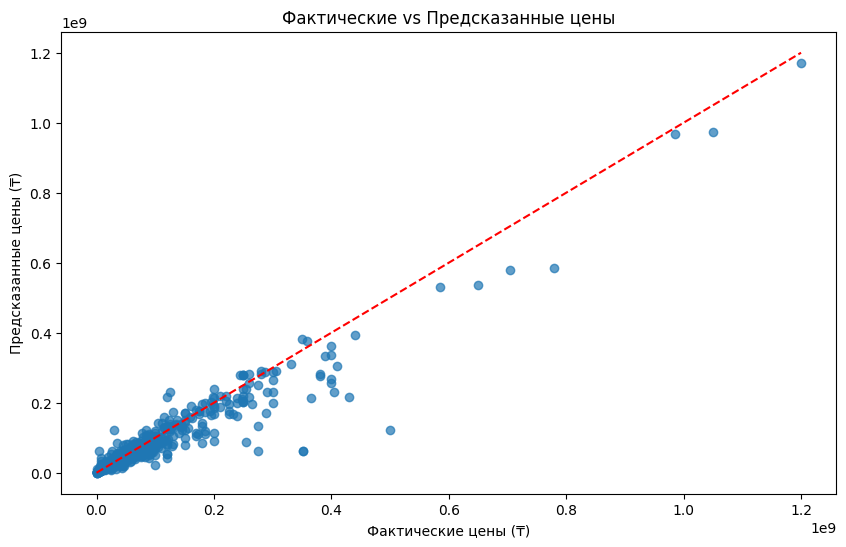

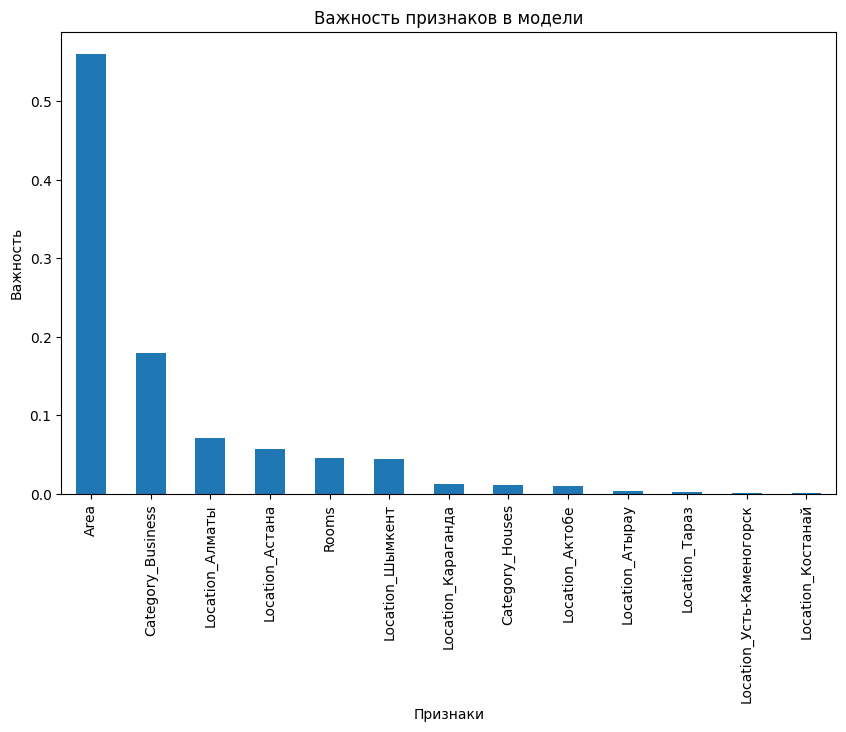

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
data = data.dropna(subset=["Price", "Area", "Rooms", "Location"])
data = data[data["Area"] <= 2000]

data["Log_Price"] = np.log1p(data["Price"])

top_locations = data["Location"].value_counts().head(10).index
data = data[data["Location"].isin(top_locations)]

features = data[["Area", "Rooms", "Category", "Location"]]
features = pd.get_dummies(features, drop_first=True)

target = data["Log_Price"]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

target_bins = pd.qcut(target, q=5, labels=False)
cv_scores = cross_val_score(model, features_scaled, target, cv=skf.split(features_scaled, target_bins), scoring="r2")

print(f"Cross-Validation R-squared scores: {cv_scores}")
print(f"Mean R-squared: {np.mean(cv_scores):.2f}")

model.fit(features_scaled, target)
y_pred = model.predict(features_scaled)

mse = mean_squared_error(target, y_pred)
r2 = r2_score(target, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(target), np.expm1(y_pred), alpha=0.7)
plt.plot([np.expm1(target).min(), np.expm1(target).max()],
         [np.expm1(target).min(), np.expm1(target).max()],
         color="red", linestyle="--")
plt.title("Фактические vs Предсказанные цены")
plt.xlabel("Фактические цены (₸)")
plt.ylabel("Предсказанные цены (₸)")
plt.show()

feature_importance = pd.Series(model.feature_importances_, index=features.columns)
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).plot(kind="bar")
plt.title("Важность признаков в модели")
plt.xlabel("Признаки")
plt.ylabel("Важность")
plt.show()